In [1]:
import sys
import pickle
import glob
import shutil
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import vgg19, inception_v3
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from torchinfo import summary
from utils import *
import warnings 
import os
warnings.filterwarnings("ignore")
import cv2
from mat4py import loadmat

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base_path = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(base_path, 'data','data_for_vgg_augmented')
train_path = os.path.join(data_path,'train')
test_path = os.path.join(data_path,'test')

In [3]:
with open('classes.txt', 'rb') as f:
    classes = pickle.load(f)

## build the model

In [4]:
num_of_classes = len(classes)
img_width, img_height = 299, 299
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device

'cuda'

In [5]:
def train_the_model():
    print('start defineing the model')
    # define the model
    model_inception_v3 = inception_v3(pretrained=True)
    
    
    # freeze feature layers
    for param in model_inception_v3.parameters():
        param.requires_grad = False
    
    # replace classification layer
    model_inception_v3.fc = nn.Linear(in_features=2048, out_features = num_of_classes)
    
    # Define the transformation for the input images
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ])

    # Load the dataset
    train_data_dir = os.path.join(data_path, 'train')
    validation_data_dir = os.path.join(data_path, 'test')

    train_dataset = ImageFolder(train_data_dir, transform=preprocess)
    validation_dataset = ImageFolder(validation_data_dir, transform=preprocess)

    # Create data loaders
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Move the model to the device
    model_inception_v3 = model_inception_v3.to(device)

    # Define the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_inception_v3.parameters(), lr=0.001)

    # Train the model
    epochs = 10

    # document statistics
    train_accuracy_per_epoch = []
    train_cross_entropy_per_epoch = []
    test_accuracy_per_epoch = []
    test_cross_entropy_per_epoch = []

    for epoch in range(epochs):
        train_loss, train_acc = 0, 0

        model_inception_v3.train()
        for inputs, y_true in train_loader:
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            y_pred = model_inception_v3(inputs)
            y_pred = y_pred[0]
            
            loss = loss_fn(y_pred, y_true)
            train_loss += loss.item() 

            optimizer.zero_grad() 

            loss.backward()

            optimizer.step()


            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y_true).sum().item()/len(y_pred)


         # Adjust metrics to get average loss and accuracy per batch 
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}")

        train_cross_entropy_per_epoch.append(train_loss)
        train_accuracy_per_epoch.append(train_acc)


        model_inception_v3.eval()
        with torch.no_grad():
            test_loss, test_acc = 0, 0

            for inputs, y_true in validation_loader:
                inputs = inputs.to(device)
                y_true = y_true.to(device)

                y_pred = model_inception_v3(inputs)
#                 y_pred = y_pred[0]
                    
                loss = loss_fn(y_pred, y_true)
                test_loss += loss.item()


                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                test_acc += (y_pred_class == y_true).sum().item()/len(y_pred)

            # Adjust metrics to get average loss and accuracy per batch 
            test_loss = test_loss / len(validation_loader)
            test_acc = test_acc / len(validation_loader)

            print(f"Validation Loss: {test_loss:.4f} - Validation Accuracy: {test_acc:.4f}")

            test_cross_entropy_per_epoch.append(test_loss)
            test_accuracy_per_epoch.append(test_acc)

    # Save the trained model
#     torch.save(model_inception_v3.state_dict(), 'inceptionv3_101_classes_model.pth')
    
    return train_cross_entropy_per_epoch, train_accuracy_per_epoch, test_cross_entropy_per_epoch, test_accuracy_per_epoch



In [6]:
# delete_all_augmented(train_path)
# reset_data(train_path, test_path)
# split_data(train_path, test_path)
# augment_images(train_path)
# train_cross_entropy_1, train_accuracy_1, test_cross_entropy_1, test_accuracy_1 = train_the_model()
# delete_all_augmented(train_path)
# reset_data(train_path, test_path)
# split_data(train_path, test_path)
# augment_images(train_path)
train_cross_entropy_2, train_accuracy_2, test_cross_entropy_2, test_accuracy_2 = train_the_model()

start defineing the model
Epoch 1/10 - Loss: 2.3816 - Accuracy: 0.4251
Validation Loss: 0.8554 - Validation Accuracy: 0.7688
Epoch 2/10 - Loss: 1.7110 - Accuracy: 0.5678
Validation Loss: 0.8261 - Validation Accuracy: 0.7900
Epoch 3/10 - Loss: 1.6596 - Accuracy: 0.5966
Validation Loss: 0.8742 - Validation Accuracy: 0.7957
Epoch 4/10 - Loss: 1.6633 - Accuracy: 0.6120
Validation Loss: 0.8767 - Validation Accuracy: 0.7981
Epoch 5/10 - Loss: 1.6797 - Accuracy: 0.6151
Validation Loss: 0.6651 - Validation Accuracy: 0.8398
Epoch 6/10 - Loss: 1.7061 - Accuracy: 0.6175
Validation Loss: 0.9915 - Validation Accuracy: 0.8042
Epoch 7/10 - Loss: 1.7166 - Accuracy: 0.6274
Validation Loss: 0.8509 - Validation Accuracy: 0.8147
Epoch 8/10 - Loss: 1.7550 - Accuracy: 0.6265
Validation Loss: 0.7923 - Validation Accuracy: 0.8328
Epoch 9/10 - Loss: 1.7602 - Accuracy: 0.6318
Validation Loss: 0.9744 - Validation Accuracy: 0.8157
Epoch 10/10 - Loss: 1.7708 - Accuracy: 0.6388
Validation Loss: 1.1259 - Validation 

In [7]:
train_cross_entropy_2

[2.3816444715313474,
 1.7109621901410523,
 1.6595972258273508,
 1.6633148939550892,
 1.6797356845438085,
 1.706101706599739,
 1.7166062156002602,
 1.755045654618828,
 1.7602122208341626,
 1.7707612841141318]

In [8]:
save_path = os.path.join(base_path, 'inception ypred ytrue')
# np.savetxt(os.path.join(save_path,'train_accuracy_1.txt'), train_accuracy_1)
# np.savetxt(os.path.join(save_path,'test_accuracy_1.txt'), test_accuracy_1)
# np.savetxt(os.path.join(save_path,'train_cross_entropy_1.txt'), train_cross_entropy_1)
# np.savetxt(os.path.join(save_path,'test_cross_entropy_1.txt'), test_cross_entropy_1)

np.savetxt(os.path.join(save_path,'train_accuracy_2.txt'), train_accuracy_2)
np.savetxt(os.path.join(save_path,'test_accuracy_2.txt'), test_accuracy_2)
np.savetxt(os.path.join(save_path,'train_cross_entropy_2.txt'), train_cross_entropy_2)
np.savetxt(os.path.join(save_path,'test_cross_entropy_2.txt'), test_cross_entropy_2)

In [52]:
delete_all_augmented(train_path)
reset_data(train_path, test_path)
split_data(train_path, test_path)
augment_images(train _path)
train_cross_entropy_1, train_accuracy_1, test_cross_entropy_1, test_accuracy_1 = train_the_model()
delete_all_augmented(train_path)
reset_data(train_path, test_path)
split_data(train_path, test_path)
augment_images(train_path)
train_cross_entropy_2, train_accuracy_2, test_cross_entropy_2, test_accuracy_2 = train_the_model()

Epoch 1/10 - Loss: 2.4102 - Accuracy: 0.4215
Validation Loss: 0.8206 - Validation Accuracy: 0.7849
Epoch 2/10 - Loss: 1.7433 - Accuracy: 0.5667
Validation Loss: 0.6853 - Validation Accuracy: 0.8232
Epoch 3/10 - Loss: 1.7172 - Accuracy: 0.5890
Validation Loss: 0.5459 - Validation Accuracy: 0.8547
Epoch 4/10 - Loss: 1.7206 - Accuracy: 0.6002
Validation Loss: 0.5065 - Validation Accuracy: 0.8604
Epoch 5/10 - Loss: 1.7501 - Accuracy: 0.6047
Validation Loss: 0.4832 - Validation Accuracy: 0.8738
Epoch 6/10 - Loss: 1.7725 - Accuracy: 0.6104
Validation Loss: 0.5970 - Validation Accuracy: 0.8457
Epoch 7/10 - Loss: 1.7800 - Accuracy: 0.6180
Validation Loss: 0.6156 - Validation Accuracy: 0.8564
Epoch 8/10 - Loss: 1.7855 - Accuracy: 0.6217
Validation Loss: 0.6018 - Validation Accuracy: 0.8635
Epoch 9/10 - Loss: 1.7900 - Accuracy: 0.6229
Validation Loss: 0.6355 - Validation Accuracy: 0.8562
Epoch 10/10 - Loss: 1.8173 - Accuracy: 0.6269
Validation Loss: 0.8460 - Validation Accuracy: 0.8418


In [10]:
save_path = os.path.join(base_path, 'inception ypred ytrue')
train_accuracy_1 = np.loadtxt(os.path.join(save_path,'train_accuracy_1.txt'))
test_accuracy_1 = np.loadtxt(os.path.join(save_path,'test_accuracy_1.txt'))
train_cross_entropy_1 = np.loadtxt(os.path.join(save_path,'train_cross_entropy_1.txt'))
test_cross_entropy_1 = np.loadtxt(os.path.join(save_path,'test_cross_entropy_1.txt'))

train_accuracy_2 = np.loadtxt(os.path.join(save_path,'train_accuracy_2.txt'))
test_accuracy_2 = np.loadtxt(os.path.join(save_path,'test_accuracy_2.txt'))
train_cross_entropy_2 = np.loadtxt(os.path.join(save_path,'train_cross_entropy_2.txt'))
test_cross_entropy_2 = np.loadtxt(os.path.join(save_path,'test_cross_entropy_2.txt'))

In [14]:
train_accuracy_average = (train_accuracy_1 + train_accuracy_2) /2
test_accuracy_average = (test_accuracy_1 + test_accuracy_2) /2

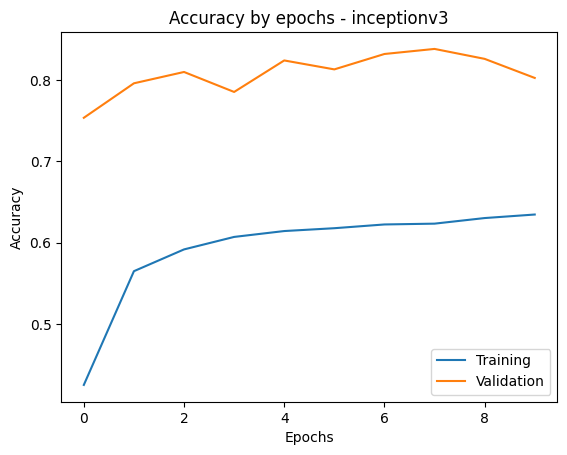

In [15]:
plt.plot(range(len(train_accuracy_average)), train_accuracy_average,
         label='Training')
plt.plot(range(len(test_accuracy_average)), test_accuracy_average,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Accuracy by epochs - inceptionv3')
plt.show()

In [16]:
test_accuracy_average[-1]

0.802490234375

In [17]:
train_cross_entropy_average = (train_cross_entropy_1 + train_cross_entropy_2) /2
test_cross_entropy_average = (test_cross_entropy_1 + test_cross_entropy_2) /2

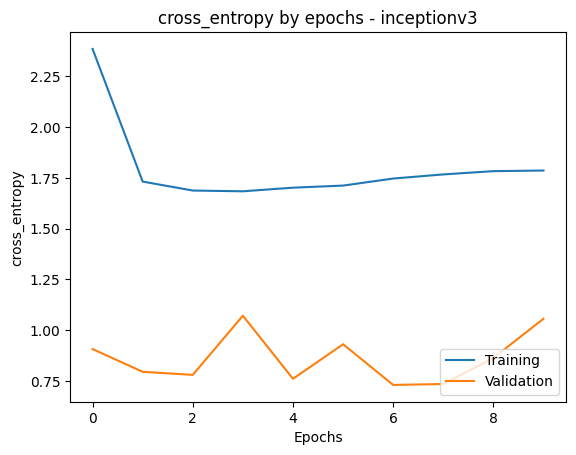

In [18]:
plt.plot(range(len(train_cross_entropy_average)), train_cross_entropy_average,
         label='Training')
plt.plot(range(len(test_cross_entropy_average)), test_cross_entropy_average,
         label='Validation')
plt.ylabel('cross_entropy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('cross_entropy by epochs - inceptionv3')
plt.show()